In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [2]:
df = pd.read_excel('Online_Retail.xlsx')

In [3]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [4]:
for col in df.columns:
  if df[col].dtype == np.object0:
    df[col] = df[col].astype(str)

In [5]:
len(df['InvoiceNo'].unique())

25900

In [6]:
df['InvoiceNo'].apply(lambda x: re.sub('[^0-9]', '', str(x)))
#df[(~df['InvoiceNo'].str.contains('[a-zA-Z]').isna()) & (df['Quantity']>0)]

0         536365
1         536365
2         536365
3         536365
4         536365
           ...  
541904    581587
541905    581587
541906    581587
541907    581587
541908    581587
Name: InvoiceNo, Length: 541909, dtype: object

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<Axes: >

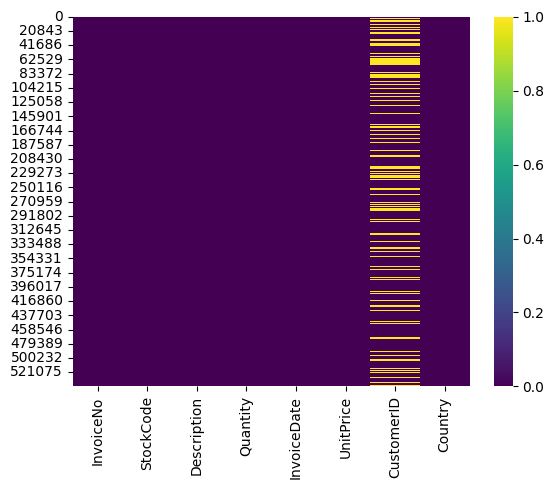

In [9]:
sns.heatmap(data=df.isnull(), cmap='viridis')

From the heatmap of missing value, we know there's significant missing on Customer's ID, which may cause potential insufficient on our analysis based on Customer(since we may have problem to groupby CustomerID)

#### Data Processing

In [10]:
# Create InvoicePrice to gather summation of total invoice price
df['InvoicePrice'] = df['UnitPrice']*df['Quantity']
df_gb_CustomerID = df.groupby('CustomerID').mean()['InvoicePrice'].reset_index()
df_gb_CustomerID.rename({'InvoicePrice':'AvgInvoicePrice'}, axis=1, inplace=True)
df = df.merge(df_gb_CustomerID, on='CustomerID', how='left',suffixes=(False, False))

<ipython-input-10-148f12872dcd>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_gb_CustomerID = df.groupby('CustomerID').mean()['InvoicePrice'].reset_index()


In [11]:
# Groupby Country
a = df.groupby(['Country'])[['AvgInvoicePrice']].mean().sort_values('AvgInvoicePrice', ascending=False)
b = df.groupby(['Country'])[['InvoiceNo']].count().sort_values('InvoiceNo', ascending=False)
c = df.groupby(['Country'])[['InvoicePrice']].sum().sort_values('InvoicePrice', ascending=False)

df_gb_Country = a.join(b)
df_gb_Country = df_gb_Country.join(c)
df_gb_Country.rename(columns={'InvoiceNo': 'NumInvoice', 'InvoicePrice':'TotalInvoicePrice'}, inplace=True) 
df_gb_Country

,AvgInvoicePrice,NumInvoice,TotalInvoicePrice
Country,,,
Netherlands,120.059696,2371,284661.540
Australia,108.540785,1259,137077.270
Japan,98.716816,358,35340.620
Sweden,79.211926,462,36595.910
Lithuania,47.458857,35,1661.060
Denmark,45.721211,389,18768.140
Singapore,39.827031,229,9120.390
Lebanon,37.641778,45,1693.880
Brazil,35.737500,32,1143.600


We notice there's a problem showing avgerage of Invoice order and sum of Invoice price, therefore we dig in to try to give more clear picture about order from **Hong Kong**.

In [12]:
df[df['Country']=='Hong Kong'].groupby('InvoiceDate').mean()

<ipython-input-12-b8b07b28a4da>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df['Country']=='Hong Kong'].groupby('InvoiceDate').mean()


,Quantity,UnitPrice,CustomerID,InvoicePrice,AvgInvoicePrice
InvoiceDate,,,,,
2011-01-24 14:24:00,19.666667,3.137895,NaN,42.802807,NaN
2011-03-15 09:44:00,-1.000000,2583.760000,NaN,-2583.760000,NaN
2011-03-15 09:50:00,1.000000,2583.760000,NaN,2583.760000,NaN
2011-04-12 09:28:00,22.875000,3.544062,NaN,48.113750,NaN
2011-05-13 14:09:00,13.569892,2.343656,NaN,21.141505,NaN
2011-06-22 10:27:00,33.562500,3.715000,NaN,39.622500,NaN
2011-08-23 09:36:00,1.000000,160.000000,NaN,160.000000,NaN
2011-08-23 09:38:00,15.312500,5.307292,NaN,55.290625,NaN
2011-09-19 16:13:00,-1.000000,2653.950000,NaN,-2653.950000,NaN


## Q1. Which region is generating the highest revenue, and which region is generating the lowest?

[Text(0, 0, 'Netherlands'),
 Text(1, 0, 'Australia'),
 Text(2, 0, 'Japan'),
 Text(3, 0, 'Sweden'),
 Text(4, 0, 'Lithuania')]

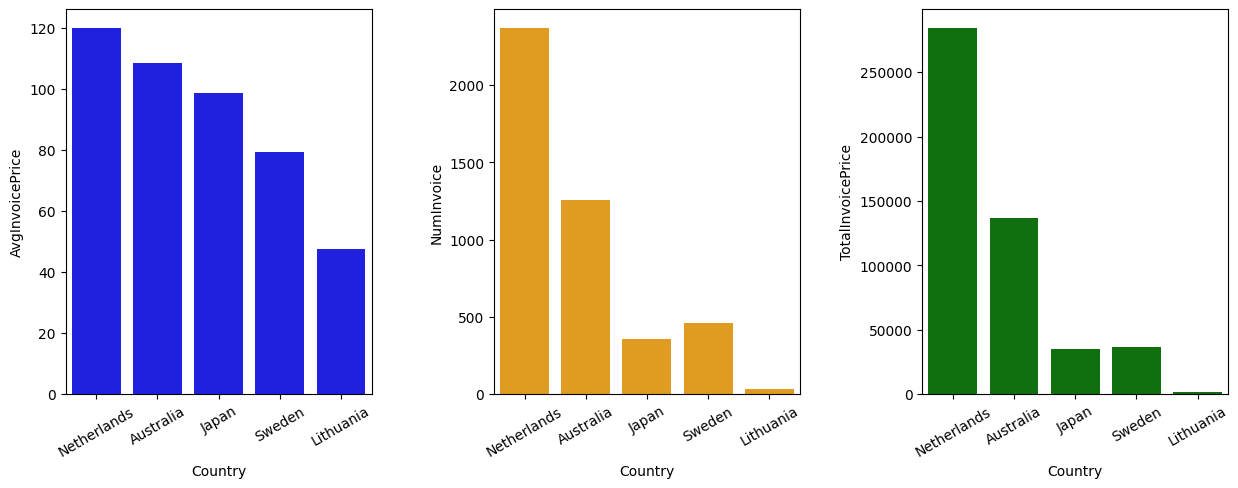

In [13]:
# create a 1x3 subplot grid
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# create a horizontal barplot for each feature and set the axes for each plot
sns.barplot(x=df_gb_Country.head(5).index, y='AvgInvoicePrice', ax=axes[0], color='blue', data=df_gb_Country.head(5))
sns.barplot(x=df_gb_Country.head(5).index, y='NumInvoice', ax=axes[1], color='orange', data=df_gb_Country.head(5))
sns.barplot(x=df_gb_Country.head(5).index, y='TotalInvoicePrice', ax=axes[2], color='green', data=df_gb_Country.head(5))
plt.subplots_adjust(wspace=0.4)
axes[0].set_xticks(range(5))
axes[0].set_xticklabels(df_gb_Country.head(5).index.tolist(), rotation=30)
axes[1].set_xticks(range(5))
axes[1].set_xticklabels(df_gb_Country.head(5).index.tolist(), rotation=30)
axes[2].set_xticks(range(5))
axes[2].set_xticklabels(df_gb_Country.head(5).index.tolist(), rotation=30)

[Text(0, 0, 'United Kingdom'),
 Text(1, 0, 'Netherlands'),
 Text(2, 0, 'EIRE'),
 Text(3, 0, 'Germany'),
 Text(4, 0, 'France'),
 Text(5, 0, 'Australia'),
 Text(6, 0, 'Switzerland'),
 Text(7, 0, 'Spain'),
 Text(8, 0, 'Belgium'),
 Text(9, 0, 'Sweden'),
 Text(10, 0, 'Japan'),
 Text(11, 0, 'Norway'),
 Text(12, 0, 'Portugal'),
 Text(13, 0, 'Finland'),
 Text(14, 0, 'Channel Islands')]

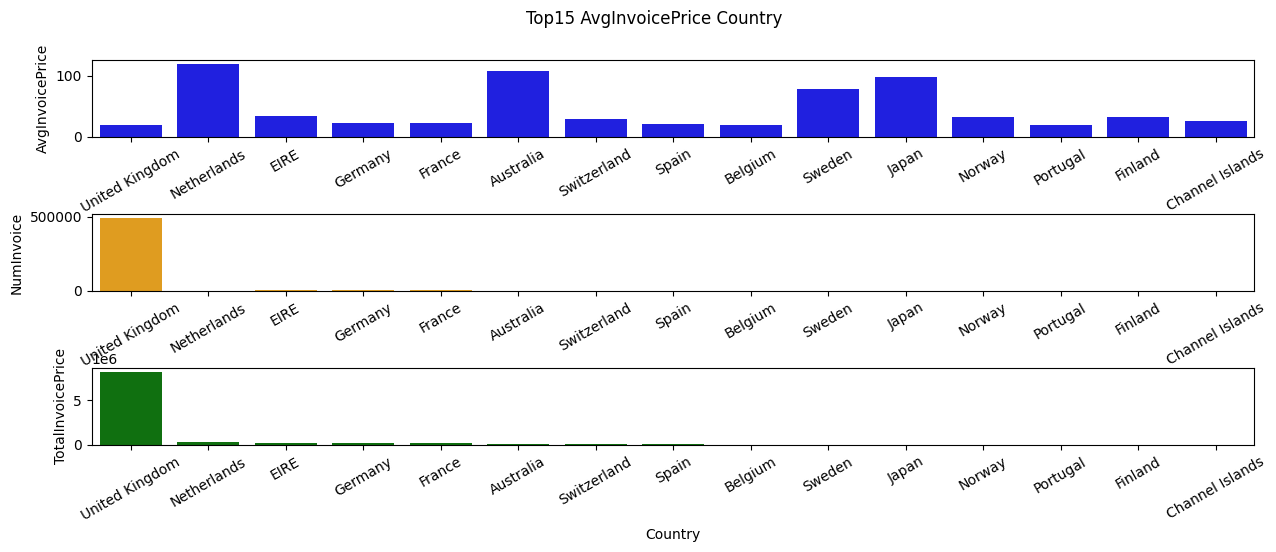

In [14]:
# create a 1x3 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,5))

#  Sort by Totalavenue
df_gb_Country = df_gb_Country.sort_values('TotalInvoicePrice', ascending=False)

# create a horizontal barplot for each feature and set the axes for each plot
sns.barplot(x=df_gb_Country.head(15).index, y='AvgInvoicePrice', ax=axes[0], color='blue', data=df_gb_Country.head(15))
sns.barplot(x=df_gb_Country.head(15).index, y='NumInvoice', ax=axes[1], color='orange', data=df_gb_Country.head(15))
sns.barplot(x=df_gb_Country.head(15).index, y='TotalInvoicePrice', ax=axes[2], color='green', data=df_gb_Country.head(15))
plt.subplots_adjust(wspace=0.4, hspace=1)
plt.suptitle("Top15 AvgInvoicePrice Country", )
axes[0].set_xlabel('')
axes[0].set_xticks(range(15))
axes[0].set_xticklabels(df_gb_Country.head(15).index.tolist(), rotation=30)
axes[1].set_xlabel('')
axes[1].set_xticks(range(15))
axes[1].set_xticklabels(df_gb_Country.head(15).index.tolist(), rotation=30)
axes[2].set_xticks(range(15))
axes[2].set_xticklabels(df_gb_Country.head(15).index.tolist(), rotation=30)

#### Countries high in Total Revenue: **United Kingdom**, **Netherlands**, **Ireland(EIRE)**, **Germany**, **France**

[Text(0, 0, 'United Kingdom'),
 Text(1, 0, 'Netherlands'),
 Text(2, 0, 'EIRE'),
 Text(3, 0, 'Germany'),
 Text(4, 0, 'France'),
 Text(5, 0, 'Australia'),
 Text(6, 0, 'Switzerland'),
 Text(7, 0, 'Spain'),
 Text(8, 0, 'Belgium'),
 Text(9, 0, 'Sweden'),
 Text(10, 0, 'Japan'),
 Text(11, 0, 'Norway'),
 Text(12, 0, 'Portugal'),
 Text(13, 0, 'Finland'),
 Text(14, 0, 'Channel Islands')]

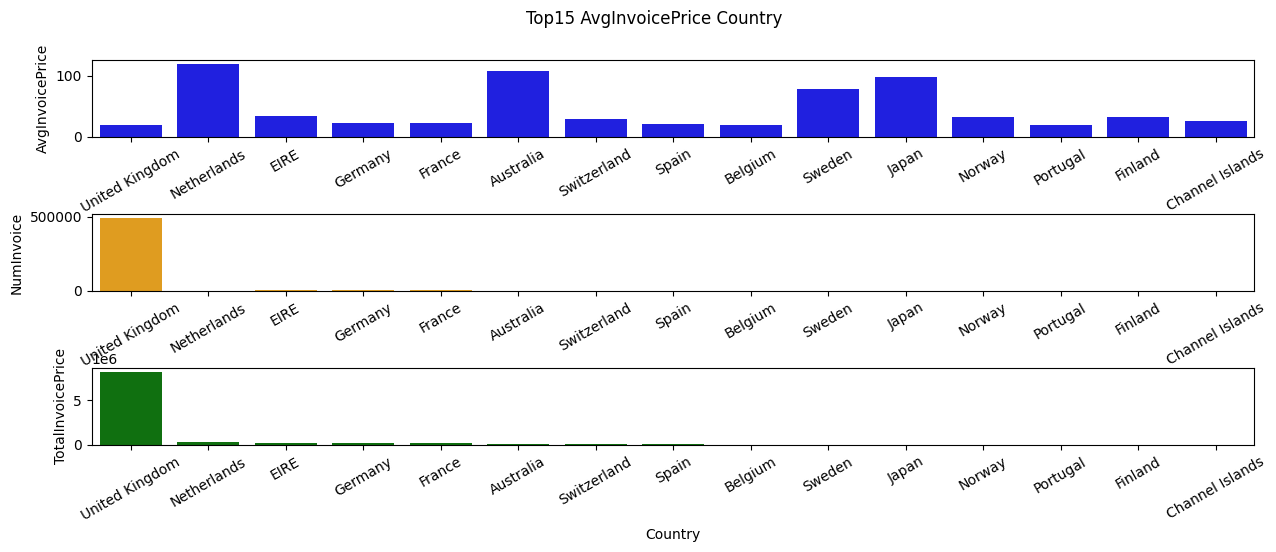

In [15]:
# create a 1x3 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,5))

# create a horizontal barplot for each feature and set the axes for each plot
sns.barplot(x=df_gb_Country.head(15).index, y='AvgInvoicePrice', ax=axes[0], color='blue', data=df_gb_Country.head(15))
sns.barplot(x=df_gb_Country.head(15).index, y='NumInvoice', ax=axes[1], color='orange', data=df_gb_Country.head(15))
sns.barplot(x=df_gb_Country.head(15).index, y='TotalInvoicePrice', ax=axes[2], color='green', data=df_gb_Country.head(15))
plt.subplots_adjust(wspace=0.4, hspace=1)
plt.suptitle("Top15 AvgInvoicePrice Country", )
axes[0].set_xlabel('')
axes[0].set_xticks(range(15))
axes[0].set_xticklabels(df_gb_Country.head(15).index.tolist(), rotation=30)
axes[1].set_xlabel('')
axes[1].set_xticks(range(15))
axes[1].set_xticklabels(df_gb_Country.head(15).index.tolist(), rotation=30)
axes[2].set_xticks(range(15))
axes[2].set_xticklabels(df_gb_Country.head(15).index.tolist(), rotation=30)


#### Countries high in Avg Order: **Netherlandas**, **Australia**, **Japan**, **Swedan**, **Lithuania**

We can further see from the graph that the company probability has mroe market share in European countrues like **Netherlands** and **Sweden** and **Ireland(EIRE)**, 

However, for countries that we haven't have larger Invoice order base like **Australia** and **Japan**, we still stike a pretty nice total sales performance from them, which brings up a suggestion to **go further in those country** since it can brings values even with fewer amount of Invoice order meaning higher ROI in expansion strategy.


[Text(0, 0, 'Denmark'),
 Text(1, 0, 'Italy'),
 Text(2, 0, 'Cyprus'),
 Text(3, 0, 'Austria'),
 Text(4, 0, 'Hong Kong'),
 Text(5, 0, 'Singapore'),
 Text(6, 0, 'Israel'),
 Text(7, 0, 'Poland'),
 Text(8, 0, 'Unspecified'),
 Text(9, 0, 'Greece'),
 Text(10, 0, 'Iceland'),
 Text(11, 0, 'Canada'),
 Text(12, 0, 'Malta'),
 Text(13, 0, 'United Arab Emirates'),
 Text(14, 0, 'USA')]

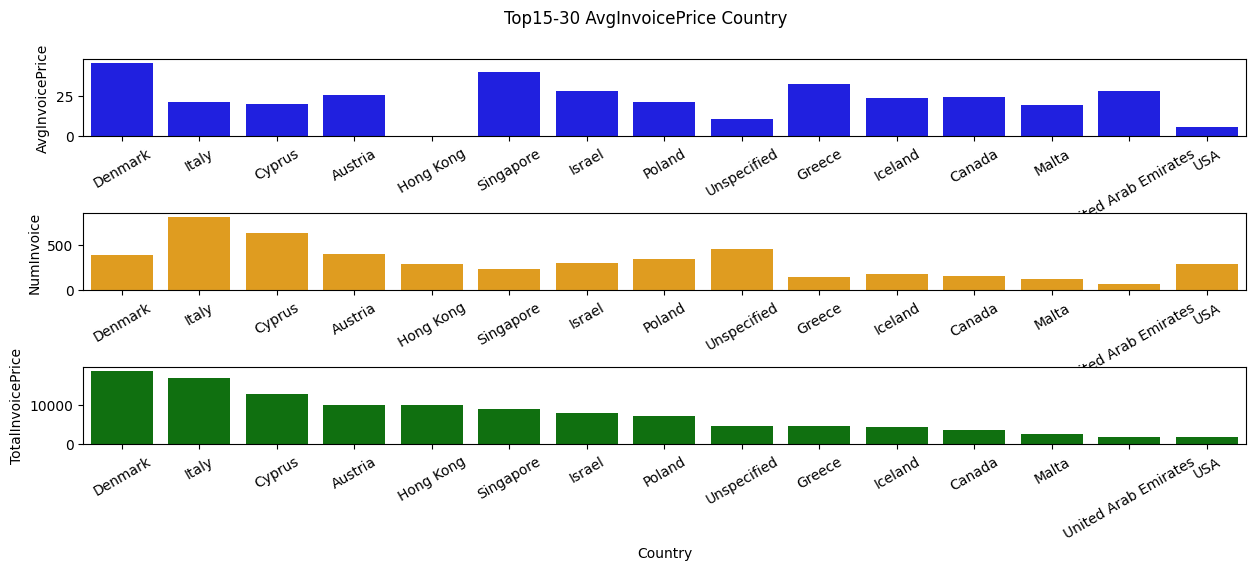

In [16]:
# create a 1x3 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,5))

# create a horizontal barplot for each feature and set the axes for each plot
sns.barplot(x=df_gb_Country[15:30].index, y='AvgInvoicePrice', ax=axes[0], color='blue', data=df_gb_Country[15:30])
sns.barplot(x=df_gb_Country[15:30].index, y='NumInvoice', ax=axes[1], color='orange', data=df_gb_Country[15:30])
sns.barplot(x=df_gb_Country[15:30].index, y='TotalInvoicePrice', ax=axes[2], color='green', data=df_gb_Country[15:30])
plt.subplots_adjust(wspace=0.4, hspace=1)
plt.suptitle("Top15-30 AvgInvoicePrice Country", )
axes[0].set_xlabel('')
axes[0].set_xticks(range(15))
axes[0].set_xticklabels(df_gb_Country[15:30].index.tolist(), rotation=30)
axes[1].set_xlabel('')
axes[1].set_xticks(range(15))
axes[1].set_xticklabels(df_gb_Country[15:30].index.tolist(), rotation=30)
axes[2].set_xticks(range(15))
axes[2].set_xticklabels(df_gb_Country[15:30].index.tolist(), rotation=30)

Combined with last bar plot, we can further drive a conclusion that we should foucs more on **how to increase the average invoice sales per order** within those countries which are **high in number of Invoice order but low in average invoice price** like Germany, France, and Spain

#### We further dive into comparing the difference between those who have potential to expand our business and those with high invoice order number but low in average total price per order.

## Q2. What are the difference between those who have high total profitable niche and and those who have low ones but have relatively huge amount of order?

In [17]:
obs_country = ['Japan', 'Australia']
com_country = ['EIRE', 'Germany', 'Spain']

obs_df = df[df['Country'].isin(obs_country)]
com_df = df[df['Country'].isin(com_country)]

display(obs_df.head(), com_df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoicePrice,AvgInvoicePrice
197,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6,2010-12-01 10:03:00,8.50,12431.0,Australia,51.0,26.734958
198,536389,21622,VINTAGE UNION JACK CUSHION COVER,8,2010-12-01 10:03:00,4.95,12431.0,Australia,39.6,26.734958
199,536389,21791,VINTAGE HEADS AND TAILS CARD GAME,12,2010-12-01 10:03:00,1.25,12431.0,Australia,15.0,26.734958
200,536389,35004C,SET OF 3 COLOURED FLYING DUCKS,6,2010-12-01 10:03:00,5.45,12431.0,Australia,32.7,26.734958
201,536389,35004G,SET OF 3 GOLD FLYING DUCKS,4,2010-12-01 10:03:00,6.35,12431.0,Australia,25.4,26.734958


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoicePrice,AvgInvoicePrice
1109,536527,22809,SET OF 6 T-LIGHTS SANTA,6,2010-12-01 13:04:00,2.95,12662.0,Germany,17.7,16.452931
1110,536527,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,6,2010-12-01 13:04:00,2.55,12662.0,Germany,15.3,16.452931
1111,536527,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,12,2010-12-01 13:04:00,0.85,12662.0,Germany,10.2,16.452931
1112,536527,22242,5 HOOK HANGER MAGIC TOADSTOOL,12,2010-12-01 13:04:00,1.65,12662.0,Germany,19.8,16.452931
1113,536527,22244,3 HOOK HANGER MAGIC GARDEN,12,2010-12-01 13:04:00,1.95,12662.0,Germany,23.4,16.452931


In [18]:
display(obs_df.groupby(['Country'])['InvoiceNo','Quantity','InvoicePrice'].mean())
display(com_df.groupby(['Country'])['InvoiceNo','Quantity','InvoicePrice'].mean())



<ipython-input-18-ea689b4ccf19>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  display(obs_df.groupby(['Country'])['InvoiceNo','Quantity','InvoicePrice'].mean())
<ipython-input-18-ea689b4ccf19>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(obs_df.groupby(['Country'])['InvoiceNo','Quantity','InvoicePrice'].mean())


,Quantity,InvoicePrice
Country,,
Australia,66.444003,108.877895
Japan,70.441341,98.716816


<ipython-input-18-ea689b4ccf19>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  display(com_df.groupby(['Country'])['InvoiceNo','Quantity','InvoicePrice'].mean())
<ipython-input-18-ea689b4ccf19>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(com_df.groupby(['Country'])['InvoiceNo','Quantity','InvoicePrice'].mean())


,Quantity,InvoicePrice
Country,,
EIRE,17.403245,32.122599
Germany,12.369458,23.348943
Spain,10.589814,21.624390


So one of the most obvious difference can be drawn here: **The average number of Quantity of products and average Total Invoice order are high in those who has high total profit with just few number of order**.

In [19]:
a = obs_df.groupby(['Country','StockCode'])['Quantity'].sum().reset_index()
a = a.groupby('Country').apply(lambda x: x.nlargest(5, 'Quantity')).reset_index(drop=True)

b = com_df.groupby(['Country','StockCode'])['Quantity'].sum().reset_index()
b = b.groupby('Country').apply(lambda x: x.nlargest(5, 'Quantity')).reset_index(drop=True)

display(a, b)

,Country,StockCode,Quantity
0,Australia,22492,2916
1,Australia,23084,1884
2,Australia,21915,1704
3,Australia,21731,1344
4,Australia,22630,1024
5,Japan,23084,3401
6,Japan,22489,1201
7,Japan,22328,870
8,Japan,22492,577
9,Japan,22531,577


,Country,StockCode,Quantity
0,EIRE,22197,1809
1,EIRE,21212,1728
2,EIRE,84991,1536
3,EIRE,21790,1492
4,EIRE,17084R,1440
5,Germany,22326,1218
6,Germany,15036,1164
7,Germany,POST,1104
8,Germany,20719,1019
9,Germany,21212,1002


Here we know that the distribution of hot items across countries are so different, in the observed countries(**Japan and Australia**), it seems like **23084**, **22492** are popular, while those two items are not there in the top 5 saling record in comparison countries.

Now we further dive deep in what kinds of items are popular across observed countris and comparison countries.

In [20]:
display(len(df['StockCode'].unique()))
display(len(df['Description'].unique()))

a = df.groupby(['StockCode']).filter(lambda x: x['Description'].nunique()>1)
a = a.groupby(['StockCode','Description']).sum()
a

4070

4224

<ipython-input-20-3beb50f935e1>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  a = a.groupby(['StockCode','Description']).sum()


Quantity  UnitPrice  \
StockCode    Description                                                
10002        INFLATABLE POLITICAL GLOBE                860      77.15   
             nan                                       177       0.00   
10080        GROOVY CACTUS INFLATABLE                  303       9.04   
             check                                      22       0.00   
             nan                                       170       0.00   
...                                                    ...        ...   
gift_0001_10 nan                                        30       0.00   
gift_0001_20 Dotcomgiftshop Gift Voucher £20.00         10     150.38   
             to push order througha s stock was         10       0.00   
gift_0001_30 Dotcomgiftshop Gift Voucher £30.00          7     175.53   
             nan                                        30       0.00   

                                                  CustomerID  InvoicePrice  \
StockCode    Description                                                     
10002        INFLATABLE POLITICAL GLOBE             723842.0        759.89   
             nan                                         0.0          0.00   
10080        GROOVY CACTUS INFLATABLE               333014.0        119.09   
             check                                       0.0          0.00   
             nan                                         0.0          0.00   
...                                                      ...           ...   
gift_0001_10 nan                                         0.0          0.00   
gift_0001_20 Dotcomgiftshop Gift Voucher £20.00          0.0        167.05   
             to push order througha s stock was          0.0          0.00   
gift_0001_30 Dotcomgiftshop Gift Voucher £30.00          0.0        175.53   
             nan                                         0.0          0.00   

                                                  AvgInvoicePrice  
StockCode    Description                                           
10002        INFLATABLE POLITICAL GLOBE                986.129985  
             nan                                         0.000000  
10080        GROOVY CACTUS INFLATABLE                  279.914792  
             check                                       0.000000  
             nan                                         0.000000  
...                                                           ...  
gift_0001_10 nan                                         0.000000  
gift_0001_20 Dotcomgiftshop Gift Voucher £20.00          0.000000  
             to push order througha s stock was          0.000000  
gift_0001_30 Dotcomgiftshop Gift Voucher £30.00          0.000000  
             nan                                         0.000000  

[3006 rows x 5 columns]

In [21]:
a = df[df['StockCode']=='23084'].groupby(['Description','Country']).count()[['Quantity']]
a = a.reset_index().merge(df_gb_Country[['NumInvoice']], on='Country')
a['InvoiceRate'] = round(a['Quantity']/a['NumInvoice'], 3)
a
#a.merge(df_gb_Country[['NumInvoice']], on='Country')

,Description,Country,Quantity,NumInvoice,InvoiceRate
0,Amazon,United Kingdom,1,495478,0.000
1,RABBIT NIGHT LIGHT,United Kingdom,888,495478,0.002
2,add stock to allocate online orders,United Kingdom,1,495478,0.000
3,allocate stock for dotcom orders ta,United Kingdom,1,495478,0.000
4,for online retail orders,United Kingdom,1,495478,0.000
5,nan,United Kingdom,10,495478,0.000
6,temp adjustment,United Kingdom,1,495478,0.000
7,website fixed,United Kingdom,1,495478,0.000
8,RABBIT NIGHT LIGHT,Australia,6,1259,0.005
9,RABBIT NIGHT LIGHT,Belgium,10,2069,0.005


In [22]:

a = df[df['Country'].isin(obs_country)].groupby(['Country', 'StockCode'])[['Quantity']].count().reset_index()
a = a.merge(df_gb_Country[['NumInvoice']], on='Country')
a['TotalInvoicePercentage'] = round(a['Quantity']/a['NumInvoice'], 3)

a = a.groupby(['Country']).apply(lambda x: x.nlargest(5, 'TotalInvoicePercentage')).reset_index(drop=True)
display(a)

b = df[df['StockCode'].isin(a.StockCode)].groupby(['StockCode']).apply(lambda x: x.nlargest(1,'Quantity')).reset_index(drop=True)

a = a.merge(b[['StockCode','Description']], on='StockCode')
a.sort_values(['Country', 'TotalInvoicePercentage'], ascending=False)

,Country,StockCode,Quantity,NumInvoice,TotalInvoicePercentage
0,Australia,22720,10,1259,0.008
1,Australia,20725,9,1259,0.007
2,Australia,21731,9,1259,0.007
3,Australia,21915,7,1259,0.006
4,Australia,22090,8,1259,0.006
5,Japan,21218,7,358,0.020
6,Japan,22661,6,358,0.017
7,Japan,22489,5,358,0.014
8,Japan,22662,5,358,0.014
9,Japan,23084,5,358,0.014


,Country,StockCode,Quantity,NumInvoice,TotalInvoicePercentage,Description
5,Japan,21218,7,358,0.020,RED SPOTTY BISCUIT TIN
6,Japan,22661,6,358,0.017,CHARLOTTE BAG DOLLY GIRL DESIGN
7,Japan,22489,5,358,0.014,PACK OF 12 TRADITIONAL CRAYONS
8,Japan,22662,5,358,0.014,LUNCH BAG DOLLY GIRL DESIGN
9,Japan,23084,5,358,0.014,RABBIT NIGHT LIGHT
0,Australia,22720,10,1259,0.008,SET OF 3 CAKE TINS PANTRY DESIGN
1,Australia,20725,9,1259,0.007,LUNCH BAG RED SPOTTY
2,Australia,21731,9,1259,0.007,RED TOADSTOOL LED NIGHT LIGHT
3,Australia,21915,7,1259,0.006,RED HARMONICA IN BOX
4,Australia,22090,8,1259,0.006,PAPER BUNTING RETROSPOT


From here, we further know that for high ROI country:

Japan, top five items are **Biscuit tin**, **Charlotte bag**, **Crayons**, **Lunch bag**, **Night light**

Australia, top five items are **Pantry design**, **Lunch bag**, **Night light**, **Harmonica**, **Paper bunting**

In [23]:
a = df[df['Country'].isin(com_country)].groupby(['Country', 'StockCode'])[['Quantity']].count().reset_index()
a = a.merge(df_gb_Country[['NumInvoice']], on='Country')
a['TotalInvoicePercentage'] = round(a['Quantity']/a['NumInvoice'], 3)

a = a.groupby(['Country']).apply(lambda x: x.nlargest(5, 'TotalInvoicePercentage')).reset_index(drop=True)
display(a)

b = df[df['StockCode'].isin(a.StockCode)].groupby(['StockCode']).apply(lambda x: x.nlargest(1,'Quantity')).reset_index(drop=True)

a = a.merge(b[['StockCode','Description']], on='StockCode')
a.sort_values(['Country','TotalInvoicePercentage'], ascending=False)

,Country,StockCode,Quantity,NumInvoice,TotalInvoicePercentage
0,EIRE,C2,108,8196,0.013
1,EIRE,22423,78,8196,0.010
2,EIRE,22699,53,8196,0.006
3,EIRE,85123A,47,8196,0.006
4,EIRE,21790,44,8196,0.005
5,Germany,POST,383,9495,0.040
6,Germany,22326,120,9495,0.013
7,Germany,22423,81,9495,0.009
8,Germany,22328,78,9495,0.008
9,Germany,22554,67,9495,0.007


,Country,StockCode,Quantity,NumInvoice,TotalInvoicePercentage,Description
8,Spain,POST,62,2533,0.024,nan
3,Spain,22423,25,2533,0.010,REGENCY CAKESTAND 3 TIER
13,Spain,22077,15,2533,0.006,6 RIBBONS RUSTIC CHARM
14,Spain,22960,16,2533,0.006,JAM MAKING SET WITH JARS
10,Spain,22326,12,2533,0.005,ROUND SNACK BOXES SET OF4 WOODLAND
7,Germany,POST,383,9495,0.040,nan
9,Germany,22326,120,9495,0.013,ROUND SNACK BOXES SET OF4 WOODLAND
2,Germany,22423,81,9495,0.009,REGENCY CAKESTAND 3 TIER
11,Germany,22328,78,9495,0.008,ROUND SNACK BOXES SET OF 4 FRUITS
12,Germany,22554,67,9495,0.007,PLASTERS IN TIN WOODLAND ANIMALS


From here, we further know that for lower ROI country:

Spain, top five items are **Regency**, **Rustic charm ribbon**, **Jam making set**, **Snack box**

Australia, top five items are **Snack box**, **Regency**, **Plasters**

EIRE, top five items are **Regency**, **Vintage snap card**

## Q2. What is the monthly trend of revenue, which months have faced the biggest increase/decrease?

## Global:

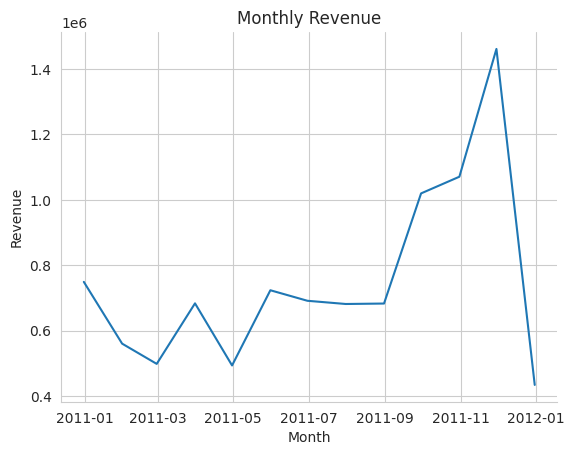

/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


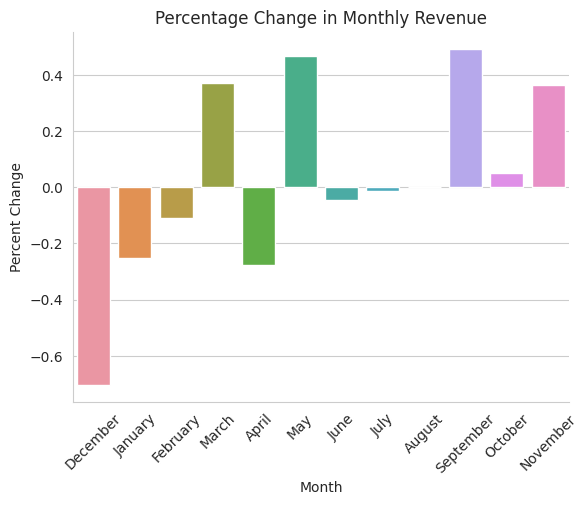

In [24]:
# Make new df indexed by InvoiceDate
dt_df = df.set_index('InvoiceDate')


# Group the data by month and calculate the total revenue for each month
monthly_revenue = dt_df['InvoicePrice'].resample('M').sum()

# Calculate the percentage change in revenue between consecutive months
monthly_revenue_pct_change = monthly_revenue.pct_change()

# Create a line plot of the monthly revenue
sns.set_style('whitegrid')
sns.lineplot(x=monthly_revenue.index, y=monthly_revenue.values)
sns.despine()
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()

# Create a bar plot of the percentage change in revenue
sns.set_style('whitegrid')
sns.barplot(x=monthly_revenue_pct_change.index.month_name(),
            y=monthly_revenue_pct_change.values)
sns.despine()
plt.title('Percentage Change in Monthly Revenue')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Percent Change')
plt.show()

## Local(United Kingdom)

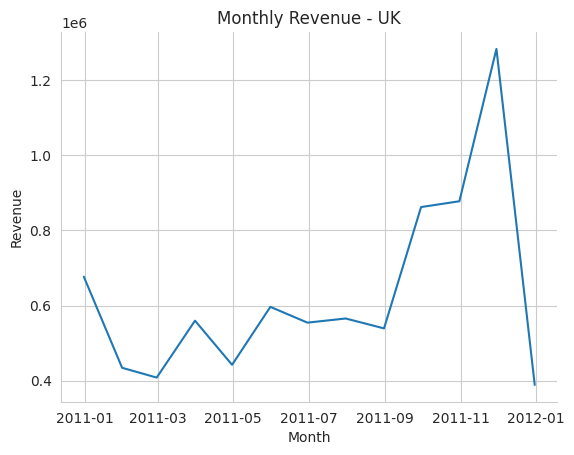

/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


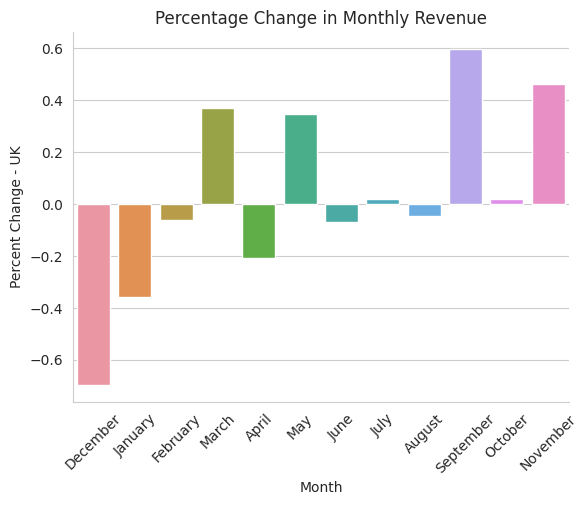

In [25]:
# Group the data by month and calculate the total revenue for each month
monthly_revenue = dt_df[dt_df['Country']=='United Kingdom']['InvoicePrice'].resample('M').sum()

# Calculate the percentage change in revenue between consecutive months
monthly_revenue_pct_change = monthly_revenue.pct_change()

# Create a line plot of the monthly revenue
sns.set_style('whitegrid')
sns.lineplot(x=monthly_revenue.index, y=monthly_revenue.values)
sns.despine()
plt.title('Monthly Revenue - UK')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()

# Create a bar plot of the percentage change in revenue
sns.set_style('whitegrid')
sns.barplot(x=monthly_revenue_pct_change.index.month_name(),
            y=monthly_revenue_pct_change.values)
sns.despine()
plt.title('Percentage Change in Monthly Revenue')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Percent Change - UK')
plt.show()

## Compact comparison

<ipython-input-26-6fbbe781f6ee>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][0].set_xticklabels(axes[i][0].get_xticklabels(), rotation=45)
/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
<ipython-input-26-6fbbe781f6ee>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][0].set_xticklabels(axes[i][0].get_xticklabels(), rotation=45)
/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
<ipython-input-26-6fbbe781f6ee>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][0].set_xticklabels(axes[i][0].get_xticklabels(), rotation=45)
/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
<ipython-i

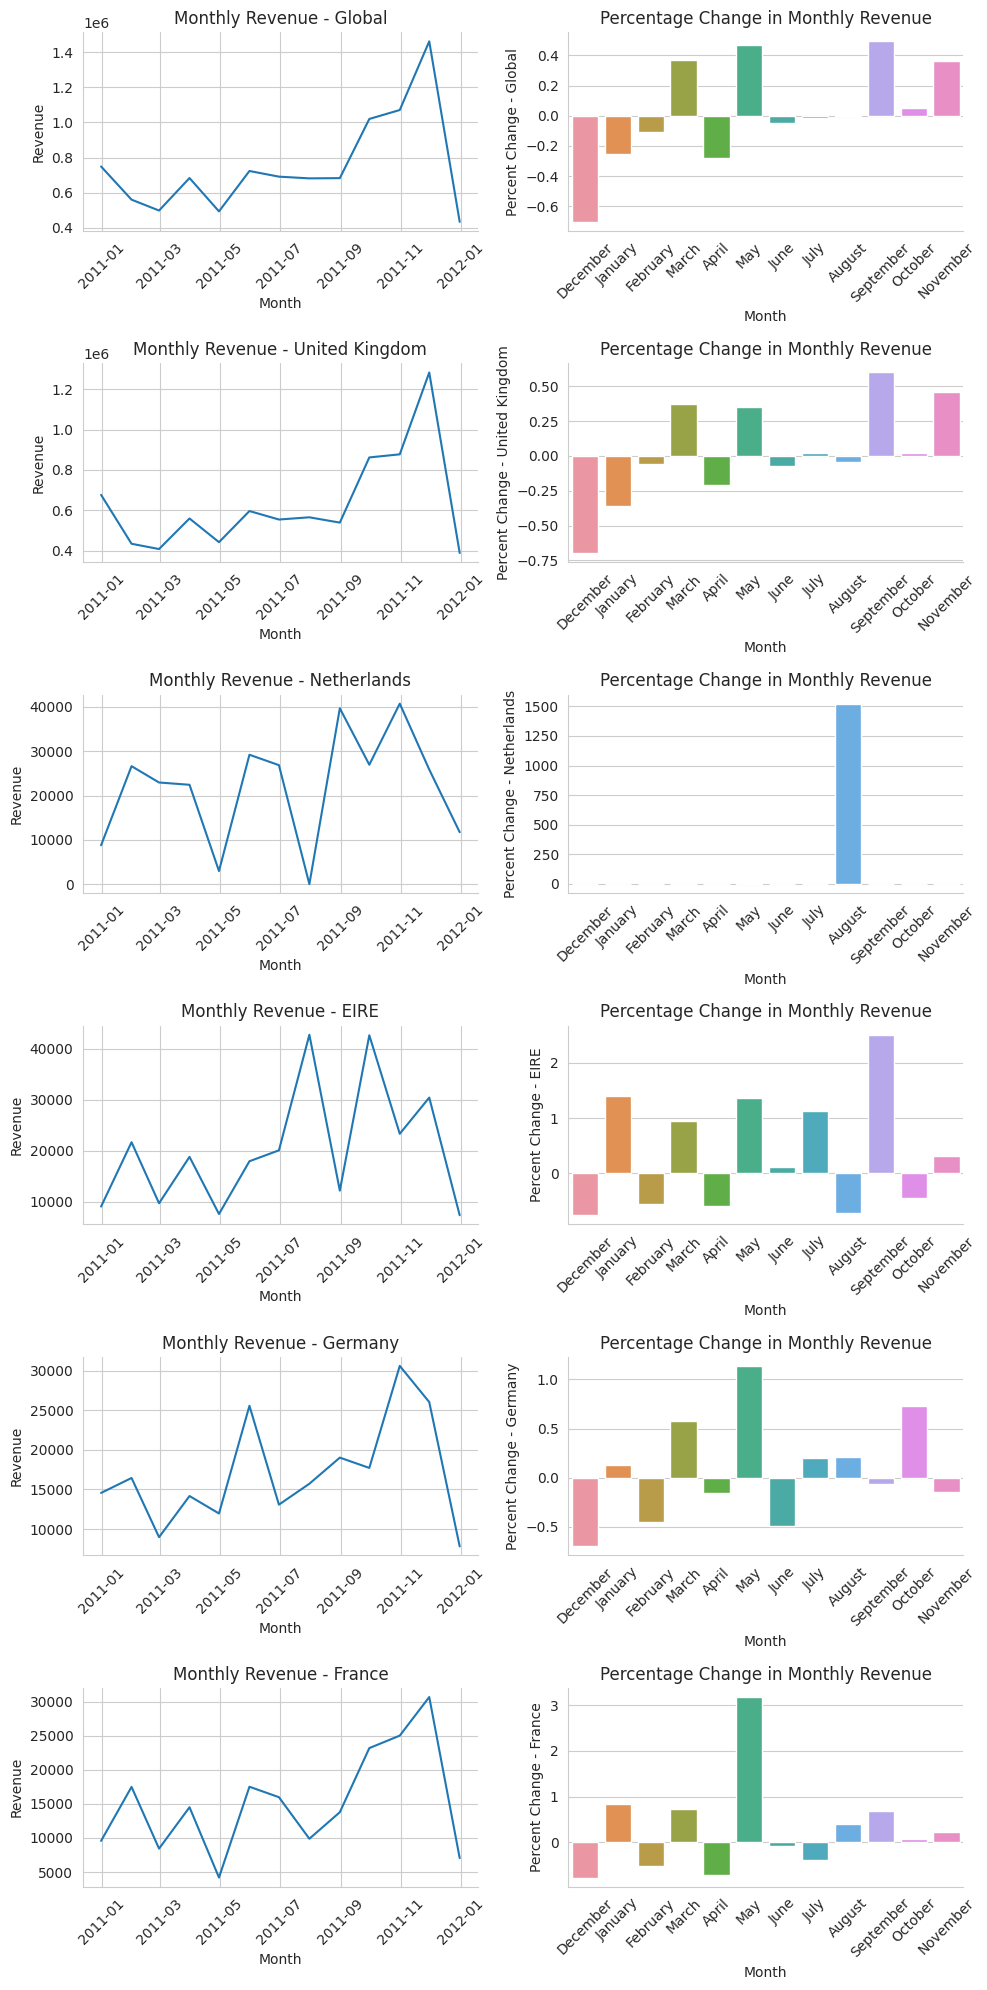

In [26]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10,20))

for i, country in enumerate(['Global', 'United Kingdom', 'Netherlands', 'EIRE', 'Germany', 'France']):
  if i==0:
    # Group the data by month and calculate the total revenue for each month
    monthly_revenue = dt_df['InvoicePrice'].resample('M').sum()
  else:
    monthly_revenue = dt_df[dt_df['Country']==country]['InvoicePrice'].resample('M').sum()

  # Calculate the percentage change in revenue between consecutive months
  monthly_revenue_pct_change = monthly_revenue.pct_change()

  # Create a line plot of the monthly revenue
  sns.lineplot(x=monthly_revenue.index, y=monthly_revenue.values, ax=axes[i][0])
  sns.despine(ax=axes[i][0])
  axes[i][0].set_title(f'Monthly Revenue - {country}')
  axes[i][0].set_xticklabels(axes[i][0].get_xticklabels(), rotation=45)
  axes[i][0].set_xlabel('Month')
  axes[i][0].set_ylabel('Revenue')

  # Create a bar plot of the percentage change in revenue
  sns.barplot(x=monthly_revenue_pct_change.index.month_name(),
              y=monthly_revenue_pct_change.values, ax=axes[i][1])
  sns.despine(ax=axes[i][1])
  axes[i][1].set_title('Percentage Change in Monthly Revenue')
  axes[i][1].set_xticklabels(axes[i][1].get_xticklabels(), rotation=45)
  axes[i][1].set_xlabel('Month')
  axes[i][1].set_ylabel('Percent Change - {}'.format(country))

plt.subplots_adjust(wspace=0.4, hspace=2) 
plt.tight_layout()
plt.show() 

There's a direct spike in September for almost all top prfiting country except for Ireland, which provide space to dig deeper if interested.

## Q3. Who are the top customers and how much do they contribute to the total revenue? Is the business dependent on these customers or is the customer base diversified?


In [27]:
customer_revenue = df.groupby('CustomerID')['InvoicePrice'].sum().reset_index()

# Sort the data in descending order by revenue
customer_revenue.sort_values(by='InvoicePrice', ascending=False, inplace=True)

# Calculate the percentage of revenue contributed by each customer
revenue_pct = customer_revenue['InvoicePrice'] / customer_revenue['InvoicePrice'].sum() * 100

print('\nPercentage of total revenue contributed by top 10 customers:')
print(revenue_pct)

# Display the top 10 customers and their revenue contribution
print(customer_revenue.head(10))


Percentage of total revenue contributed by top 10 customers:
1703    3.367311
4233    3.089596
3758    2.258803
1895    1.597248
55      1.490656
          ...   
125    -0.013566
3870   -0.014040
1384   -0.014364
2236   -0.019186
3756   -0.051658
Name: InvoicePrice, Length: 4372, dtype: float64
      CustomerID  InvoicePrice
1703     14646.0     279489.02
4233     18102.0     256438.49
3758     17450.0     187482.17
1895     14911.0     132572.62
55       12415.0     123725.45
1345     14156.0     113384.14
3801     17511.0      88125.38
3202     16684.0      65892.08
1005     13694.0      62653.10
2192     15311.0      59419.34


In [28]:
customer_revenue

,CustomerID,InvoicePrice
1703,14646.0,279489.02
4233,18102.0,256438.49
3758,17450.0,187482.17
1895,14911.0,132572.62
55,12415.0,123725.45
...,...,...
125,12503.0,-1126.00
3870,17603.0,-1165.30
1384,14213.0,-1192.20
2236,15369.0,-1592.49


## Q4. What is the percentage of customers who are repeating their orders? Are they ordering the same products or different?

In [30]:
# Count the number of unique customers
unique_customers = df['CustomerID'].nunique()

# Count the number of customers with multiple orders
repeat_customers = (df.groupby('CustomerID').size() > 1).sum()

# Calculate the percentage of repeat customers
repeat_customer_pct = (repeat_customers / unique_customers) * 100

print(f"Percentage of repeat customers: {repeat_customer_pct:.2f}%")

Percentage of repeat customers: 98.19%


In [31]:
# Group the data by CustomerID and StockCode
customer_orders = df.groupby(['CustomerID', 'StockCode']).size()

# Count the number of customers who have ordered the same product multiple times
repeat_product_customers = len(df[df['CustomerID'].isin(customer_orders.reset_index()['CustomerID'].unique())]['CustomerID'].unique())

# Count the number of customers who have ordered multiple products
diversified_customers = (customer_orders.groupby('CustomerID').size() > 1).sum()

print(f"Percentage of customers who are repeating their orders for the same product: {(repeat_product_customers / unique_customers) * 100:.2f}%")
print(f"Percentage of customers who are diversified: {(diversified_customers / unique_customers) * 100:.2f}%")

Percentage of customers who are repeating their orders for the same product: 100.00%
Percentage of customers who are diversified: 97.67%


## Q5. For the repeat customers, how long does it take for them to place the next order after being delivered the previous one?

In [32]:
# Create a DataFrame of customer order dates
customer_order_dates = df[['CustomerID', 'InvoiceDate']].drop_duplicates()

# Sort the DataFrame by CustomerID and InvoiceDate
customer_order_dates.sort_values(['CustomerID', 'InvoiceDate'], inplace=True)

# Group the DataFrame by CustomerID and calculate the time difference between consecutive orders
customer_order_dates['time_diff'] = customer_order_dates.groupby('CustomerID')['InvoiceDate'].diff()

# Remove the first order for each customer, since there is no previous order to calculate the time difference with
customer_order_dates = customer_order_dates.dropna()

# Display the time differences between consecutive orders for repeat customers
repeat_customers = customer_order_dates['CustomerID'].value_counts()[customer_order_dates['CustomerID'].value_counts() > 1]
mean_time_diff = customer_order_dates[customer_order_dates['CustomerID'].isin(repeat_customers.index)]['time_diff'].mean()

print('Mean time difference between orders for repeat customers:', mean_time_diff)

#for customer in repeat_customers.index:
#    print('Customer ID:', customer)
#    print('Time between consecutive orders:')
#    print(customer_order_dates[customer_order_dates['CustomerID'] == customer]['time_diff'])

Mean time difference between orders for repeat customers: 30 days 03:31:03.576347661


In [33]:
# Group the data by customer ID and sort the orders by delivery date
grouped = df.groupby('CustomerID').apply(lambda x: x.sort_values('InvoiceDate'))

# Calculate the time difference between consecutive orders for each customer
grouped['TimeSinceLastOrder'] = grouped['InvoiceDate'].diff()

# Filter the data to only include repeat customers
grouped[grouped['TimeSinceLastOrder'].notnull()]

InvoiceNo StockCode                          Description  \
CustomerID                                                                   
12346.0    61624    C541433     23166       MEDIUM CERAMIC TOP STORAGE JAR   
12347.0    14938     537626     85116      BLACK CANDELABRA T-LIGHT HOLDER   
           14968     537626     20782       CAMOUFLAGE EAR MUFF HEADPHONES   
           14967     537626     20780            BLACK EAR MUFF HEADPHONES   
           14966     537626    84558A         3D DOG PICTURE PLAYING CARDS   
...                     ...       ...                                  ...   
18287.0    392732    570715     21481           FAWN BLUE HOT WATER BOTTLE   
           392725    570715     21824  PAINTED METAL STAR WITH HOLLY BELLS   
           423940    573167     21824  PAINTED METAL STAR WITH HOLLY BELLS   
           423939    573167     23264   SET OF 3 WOODEN SLEIGH DECORATIONS   
           423941    573167     21014        SWISS CHALET TREE DECORATION    

                   Quantity         InvoiceDate  UnitPrice  CustomerID  \
CustomerID                                                               
12346.0    61624     -74215 2011-01-18 10:17:00       1.04     12346.0   
12347.0    14938         12 2010-12-07 14:57:00       2.10     12347.0   
           14968          6 2010-12-07 14:57:00       5.49     12347.0   
           14967         12 2010-12-07 14:57:00       4.65     12347.0   
           14966         24 2010-12-07 14:57:00       2.95     12347.0   
...                     ...                 ...        ...         ...   
18287.0    392732         4 2011-10-12 10:23:00       3.75     18287.0   
           392725        24 2011-10-12 10:23:00       0.39     18287.0   
           423940        48 2011-10-28 09:29:00       0.39     18287.0   
           423939        36 2011-10-28 09:29:00       1.25     18287.0   
           423941        24 2011-10-28 09:29:00       0.29     18287.0   

                          Country  InvoicePrice  AvgInvoicePrice  \
CustomerID                                                         
12346.0    61624   United Kingdom     -77183.60         0.000000   
12347.0    14938          Iceland         25.20        23.681319   
           14968          Iceland         32.94        23.681319   
           14967          Iceland         55.80        23.681319   
           14966          Iceland         70.80        23.681319   
...                           ...           ...              ...   
18287.0    392732  United Kingdom         15.00        26.246857   
           392725  United Kingdom          9.36        26.246857   
           423940  United Kingdom         18.72        26.246857   
           423939  United Kingdom         45.00        26.246857   
           423941  United Kingdom          6.96        26.246857   

                  TimeSinceLastOrder  
CustomerID                            
12346.0    61624     0 days 00:16:00  
12347.0    14938  -42 days +04:40:00  
           14968     0 days 00:00:00  
           14967     0 days 00:00:00  
           14966     0 days 00:00:00  
...                              ...  
18287.0    392732    0 days 00:00:00  
           392725    0 days 00:00:00  
           423940   15 days 23:06:00  
           423939    0 days 00:00:00  
           423941    0 days 00:00:00  

[406828 rows x 11 columns]

## Q6. What revenue is being generated from the customers who have ordered more than once?

In [34]:
# Create a DataFrame of all orders made by repeat customers
repeat_orders = df[df['CustomerID'].isin(repeat_customers.index)]

# Calculate the total revenue for each repeat customer
customer_revenue = repeat_orders.groupby('InvoiceNo')['InvoicePrice'].sum()

# Sum the revenue generated by all repeat customers
total_revenue_repeat_customers = customer_revenue.sum()

# Sum the revenue generated by all customers
total_revenue_cutomers = df.groupby('InvoiceNo')['InvoicePrice'].sum().sum()

print('Total revenue generated from repeat customers: {}'.format(total_revenue_repeat_customers))
print('Total revenue percentage generated from repeat customers: {}%'.format(total_revenue_repeat_customers/total_revenue_cutomers*100))

Total revenue generated from repeat customers: 7415862.7930000005
Total revenue percentage generated from repeat customers: 76.07770372409387%


In [35]:
# Group the customer_order_dates DataFrame by CustomerID and count the number of orders for each customer
customer_order_counts = customer_order_dates.groupby('CustomerID')['InvoiceDate'].count().reset_index()

# Rename the InvoiceDate column to order_count
customer_order_counts = customer_order_counts.rename(columns={'InvoiceDate': 'order_count'})

# Sort the customer_order_counts DataFrame by order_count in descending order
customer_order_counts = customer_order_counts.sort_values('order_count', ascending=False)

# Merge the customer_order_counts DataFrame with the df DataFrame to get the total revenue for each customer
customer_revenue = df.groupby('CustomerID')['InvoicePrice'].sum().reset_index()

# Merge the customer_order_counts and customer_revenue DataFrames
customer_summary = pd.merge(customer_order_counts, customer_revenue, on='CustomerID')

# Calculate the contribution to revenue for each customer
customer_summary['revenue_contribution'] = customer_summary['InvoicePrice'] / customer_summary['InvoicePrice'].sum()

# Map country back to summary df
customer_summary = customer_summary.merge(df[['CustomerID','Country']].drop_duplicates(subset='CustomerID', keep='first'), on='CustomerID')

# Display the top 10 customers who have repeated the most and their contribution to revenue
print(customer_summary.head(10))

   CustomerID  order_count  InvoicePrice  revenue_contribution         Country
0     14911.0          247     132572.62              0.016859            EIRE
1     12748.0          224      29072.10              0.003697  United Kingdom
2     17841.0          167      40340.78              0.005130  United Kingdom
3     14606.0          128      11713.85              0.001490  United Kingdom
4     15311.0          117      59419.34              0.007556  United Kingdom
5     13089.0          113      57385.88              0.007298  United Kingdom
6     12971.0           85      10930.26              0.001390  United Kingdom
7     14527.0           84       7711.38              0.000981  United Kingdom
8     13408.0           76      27487.41              0.003496  United Kingdom
9     14646.0           76     279489.02              0.035542     Netherlands


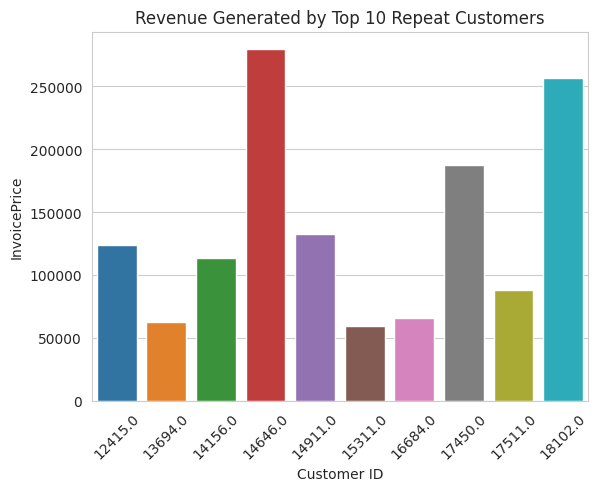

In [36]:
top_10_customers = customer_summary.sort_values('InvoicePrice', ascending=False).head(10).reset_index()

sns.barplot(data = top_10_customers, x='CustomerID', y='InvoicePrice')
plt.title('Revenue Generated by Top 10 Repeat Customers')
plt.xlabel('Customer ID')
plt.ylabel('InvoicePrice')
plt.xticks(rotation=45)
plt.show()

In [37]:
# Create a DataFrame of customer revenue
customer_revenue = df.groupby('CustomerID')['InvoicePrice'].sum()

# Create a boolean mask for customers who have ordered more than once
repeat_customers_mask = df['CustomerID'].duplicated(keep=False)

# Calculate the revenue generated by repeat customers
repeat_customer_revenue = customer_revenue[repeat_customers_mask]
repeat_customer_revenue

CustomerID
12346.0       0.00
12347.0    4310.00
12348.0    1797.24
12349.0    1757.55
12350.0     334.40
            ...   
18280.0     180.60
18281.0      80.82
18282.0     176.60
18283.0    2094.88
18287.0    1837.28
Name: InvoicePrice, Length: 4372, dtype: float64

In [38]:
# Filter out the countries with less than 10 customers
a = customer_summary[(customer_summary.groupby('Country')['CustomerID'].transform('size') > 10) & (customer_summary.groupby('Country')['CustomerID'].transform('size') <= 50)]

# Group by CustomerID
grouped_summary = a.groupby('CustomerID').agg({'order_count': 'sum', 'InvoicePrice': 'sum', 'revenue_contribution': 'sum'}).reset_index()

# Map the country back
a = grouped_summary.merge(customer_summary[['CustomerID','Country']], on='CustomerID')

# Print the grouped summary
print(a.head(10))

   CustomerID  order_count  InvoicePrice  revenue_contribution      Country
0     12356.0            2       2811.43              0.000358     Portugal
1     12362.0           12       5154.58              0.000655      Belgium
2     12364.0            3       1313.10              0.000167      Belgium
3     12371.0            1       1887.96              0.000240  Switzerland
4     12377.0            1       1628.12              0.000207  Switzerland
5     12379.0            2        850.29              0.000108      Belgium
6     12380.0            4       2720.56              0.000346      Belgium
7     12383.0            5       1839.31              0.000234      Belgium
8     12384.0            2        566.16              0.000072  Switzerland
9     12394.0            1       1272.48              0.000162      Belgium


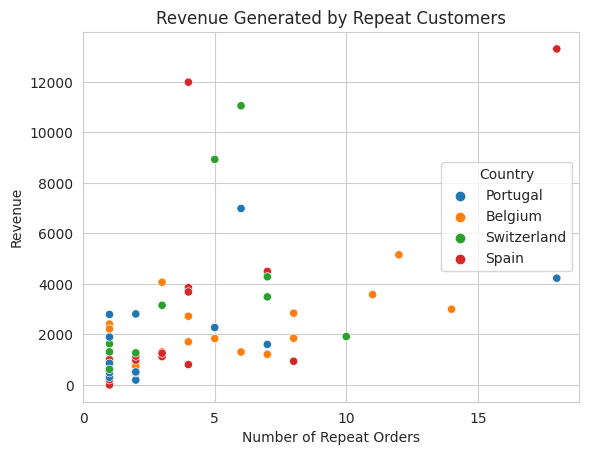

In [39]:
customer_summary

# Scatter plot
sns.scatterplot(data=a.head(1000), x='order_count', y='InvoicePrice', hue='Country')
plt.title('Revenue Generated by Repeat Customers')
plt.xlabel('Number of Repeat Orders')
plt.ylabel('Revenue')

# Set the xticks to integer interval
plt.xticks(range(0, a.head(1000)['order_count'].max()+1, 5))

plt.show()